# ВЫБОР МЕТРИКИ В ЗАДАЧЕ «СТРУКТУРА-СВОЙСТВО» ДЛЯ ПОСТРОЕНИЯ ОБОБЩЕННОГО ДЕРЕВА РЕШЕНИЙ #

In [2]:
import inputdata
import klustmatr
import ODR
import alg

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Входные данные ##
### Признаки ###
  
В качестве примера рассмотрим выборку `DB_GLASS`. Выборка `DB_GLASS` содержит 103 структуры полимеров. Целевым свойством является температура стеклования – температура, при которой некоторые свойства жидкости, такие как коэффициент теплового расширения и теплоемкость изменяются от их значений в жидком состоянии до значений, аналогичных значениям кристаллического твердого тела.

In [3]:
dir_name = inputdata.read_dir()

select data directory:
 1 - DB_AMN
 2 - DB_CANCERF4
 3 - DB_GLASS


 3


Для описания каждой выборки формируются МД-матрицы.  
Сложность описания М-графов индуктивно увеличивается. Признаками М-графа являются его инварианты, для конструирования которых вводится алфавит примитивов, описывающих графы.  
Сложность описания химических структур зависит от уровня инвариантов (число примитивов, для которых считается количество повторений) k = 1, 2, 3 и количества включенных маркеров m = 1, 2,3.

In [4]:
file_name = inputdata.read_file()

select file:
 1 - matrk1m3.txt
 2 - matrk2m1.txt
 3 - matrk2m2.txt
 4 - matrk2m3.txt
 5 - matrk3m1.txt
 6 - matrk3m2.txt
 7 - matrk3m3.txt


 4


Для визуализации, спроектируем данные на плоскость с помощью алгоритма PCA.

In [5]:
dim = inputdata.read_PCA()

select dimension of feature space:
 1 - PCA (1 principal component)
 2 - PCA (2 principal components)
 3 - PCA (3 principal components)
 4 - all features


 2


### Свойства ###
Из файла `propeties.txt` считываем размер MD-матрицы, после чего считываем MD-матрицу `X` и вектор свойств `Y`.

In [6]:
x_len, y_len = inputdata.get_propeties(dir_name + "propeties.txt", file_name)
X = inputdata.get_matr(dir_name + file_name, x_len, y_len)
if ("DB_AMN" in dir_name):
    Y = inputdata.get_propities_DB_AMN(dir_name + "propeties.txt", y_len)
elif ("DB_CANCERF4" in dir_name):
    Y = inputdata.get_propeties_DB_CANCERF4_A1(dir_name + "propeties.txt", y_len)
elif ("DB_GLASS" in dir_name):
    Y = inputdata.get_propeties_DB_GLASS(dir_name + "propeties.txt", y_len)

Нормализуем данные и применяем применяем алгоритм PCA.

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  
pca = PCA(n_components = dim)
PrincipalComp = pca.fit_transform(X_scaled)

Визуализируем данные.

plot result (y/n):  y


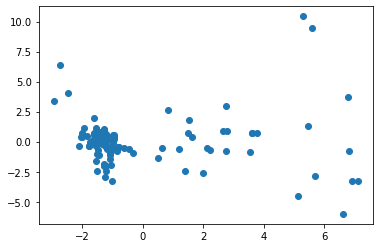

In [7]:
enter = input("plot result (y/n): ")
if enter.startswith('y'):
    klustmatr.plot_PC(dim, PrincipalComp)

## Модель ##
Модель строится на основе гребневой регрессии с оценкой $R^2$

In [ ]:
from sklearn.linear_model    import Ridge

def ridge(X_train, X_test, y_train, y_test):
    res = 0
    first = True
    for alfa in {0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100}:
        model = Ridge(alpha = alfa).fit(X_train, y_train)
        if (len(y_test) == 1):
           current_res = 1 - (y_test[0] - model.predict(X_test)[0])**2 / (4*y_test[0])
        else:        
            current_res = model.score(X_test, y_test)
    
    if current_res > res or first:
                res = current_res
                prediction =  model.predict(X_test)
                first = False
    
    return res, prediction   

На вход функции подаются:
- число кластеров `n_clusters`
- метки кластеров для обучающей и тестовой выборки `y_alg_train`,`y_alg_test` 
- обучающая и тестовая выборки `X_train`,`Y_train` и `X_test`,`Y_test`

Для каждого кластера отбираем все точки из обучающей и тестовой выборок, попавших в него. По отобранным точкам из тестовой выборки строим модель гребневой регрессии. Далее выполняется прогноз.
Если точки из тестовой выборки не попали ни в один кластер или в кластере нет точек из обучающей выборки, то выполняется отказ от прогноза и эти точки не учувствуют в оценке качества ОДР.

In [ ]:
def ridge_model_cluster(n_clusters, y_alg_train, y_alg_test, X_train, X_test,\
                        Y_train, Y_test):
    Y_res     = list()
    Y_compare = list()
    markers = [None]*n_clusters
    n = 0
    
    for i in range(n_clusters):
        if (n < len(y_alg_test)):
            beg = 0
            while (klustmatr.in_markers(markers,i,y_alg_test[beg]) and beg < len(y_alg_test)-1):
                beg += 1
            markers[i] = y_alg_test[beg]
        
            X_clust_train, y_clust_train = klustmatr.get_cluster_points(\
                  X_train, Y_train, markers[i], y_alg_train, len(y_alg_train))
            X_clust_test,  y_clust_test  = klustmatr.get_cluster_points(\
                                X_test, Y_test, markers[i], y_alg_test, len(y_alg_test))
            
            if (len(y_clust_test) > 0 and len(y_clust_train) > 0):
                Y_compare += y_clust_test
                ridge_res, y_res = ridge(X_clust_train, X_clust_test,
                                               y_clust_train, y_clust_test)
                Y_res += y_res.tolist()
                n += len(y_res)
    
    if (len(Y_res) > 1):        
        return r2_score(Y_compare, Y_res)
    elif(len(Y_res) == 1):
        return 1 - (Y_compare[0] - Y_res[0])**2 / (4*Y_compare[0])
    else:
        return -10000

## Пример ##

Для начала воспользуемся обычной гребневой регрессией, без ОДР.  
Видим, что $R^2$ оценка на тестовом множестве составляет `0.81`.

In [9]:
alg.user_models(PrincipalComp,Y,dim)

cluster analysis algorithm (y/n):  n


Ridge (optimal alfa  10 ):
Correctness on training set: 0.81
Correctness on testing  set: 0.81



another algorithm (y/n):  n


<br/>Теперь попробуем построить ОДР, используя алгоритм k-means и стандартную евклидову метрику. Число кластеров зададим равное `5`.  
Результат разбиения множества признаков на кластеры показан ниже. Причем, большими точками обозначены объекты тестовой выборки, а маленькими - обучающей.
Второе изображении - это профиль кластера.
Также выводится сводная табличка, которая содержит информацию о среднем вектора свойств точек, попавших в кластер (это вещественные числа), количестве точек в кластере, а также отрезке, в котором лежат все значения признака.

В конце выводится оченка качества модели.   
Видим, что $R^2$ оценка на тестовом множестве составляет `0.95`

cluster analysis algorithm (y/n):  y


select cluster analysis algorithm:
 1 - k-means
 2 - EM
 3 - DBSCAN
 4 - None


 1
   number of clusters:  5
information about clusters (y/n)?  y


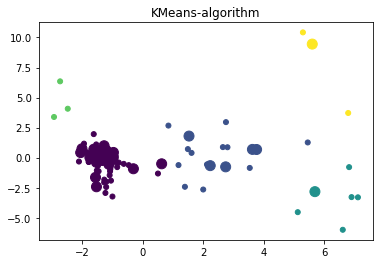

K-Means:
train-clusters propeties:
information obout cluster propeties:
cluster  0  : mean  123.5  , n of points  54  , [ 73.0  ,  213.0 ]
cluster  4  : mean  404.0  , n of points  2  , [ 353.0  ,  455.0 ]
cluster  1  : mean  363.077  , n of points  13  , [ 240.0  ,  440.0 ]
cluster  3  : mean  182.667  , n of points  3  , [ 176.0  ,  188.0 ]
cluster  2  : mean  406.0  , n of points  5  , [ 388.0  ,  417.0 ]
Markers :  [0, 4, 1, 3, 2]
Errors  :  [7305.0, 510.0, 2993.846, 66.667, 180.0]



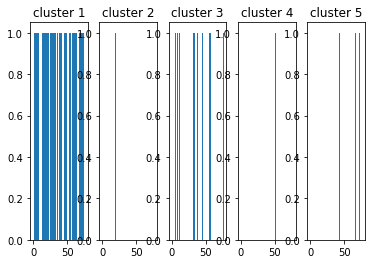

PCA:  2 components
cluster analysis algorithm: K-Means
Correctness on testing  set: 0.95



another algorithm (y/n):  n


In [10]:
alg.user_models(PrincipalComp,Y,dim)

<br/>Теперь попробуем построить ОДР, используя алгоритм DBSCAN с параметрами `eps = 2`, `min_samples = 5` и стандартную евклидову метрику.

Видим, что $R^2$ оценка на тестовом множестве составляет `0.91`

cluster analysis algorithm (y/n):  y


select cluster analysis algorithm:
 1 - k-means
 2 - EM
 3 - DBSCAN
 4 - None


 3
   eps (for ex. 2):  2
   min_samples (for ex. 2):  5


select cmetric:
 1 - Euclidean
 2 - Minkowski
 3 - Chebyshev



 1
information about clusters (y/n)?  y


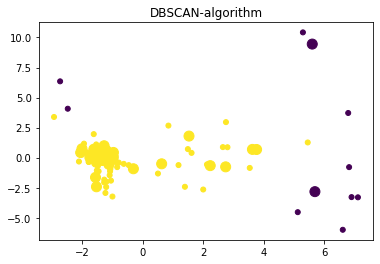

DBSCAN:
train-clusters propeties:
information obout cluster propeties:
cluster  0  : mean  170.25  , n of points  68  , [ 73.0  ,  440.0 ]
cluster  -1  : mean  355.333  , n of points  9  , [ 176.0  ,  455.0 ]
Markers :  [0, -1]
Errors  :  [10585.0, 1412.0]



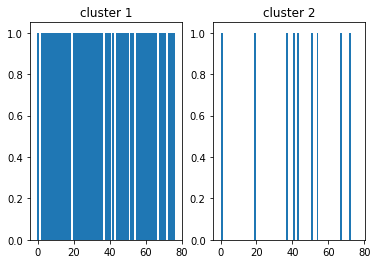

PCA:  2 components
cluster analysis algorithm: K-Means
Correctness on testing  set: 0.91



another algorithm (y/n):  n


In [8]:
alg.user_models(PrincipalComp,Y,dim)

<br/>Теперь попробуем построить ОДР, используя алгоритм DBSCAN с параметрами `eps = 2`, `min_samples = 5` метрику чебышева.  
Заметим, что кластеры изменились.

Видим, что $R^2$ оценка на тестовом множестве составляет `0.91`

cluster analysis algorithm (y/n):  y


select cluster analysis algorithm:
 1 - k-means
 2 - EM
 3 - DBSCAN
 4 - None


 3
   eps (for ex. 2):  2
   min_samples (for ex. 2):  5


select cmetric:
 1 - Euclidean
 2 - Minkowski
 3 - Chebyshev



 3
information about clusters (y/n)?  y


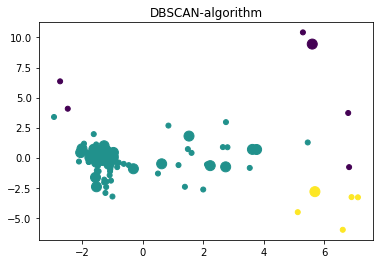

DBSCAN:
train-clusters propeties:
information obout cluster propeties:
cluster  0  : mean  170.25  , n of points  68  , [ 73.0  ,  440.0 ]
cluster  -1  : mean  315.0  , n of points  5  , [ 176.0  ,  455.0 ]
cluster  1  : mean  405.75  , n of points  4  , [ 388.0  ,  417.0 ]
Markers :  [0, -1, 1]
Errors  :  [15877.5, 1620.0, 106.5]



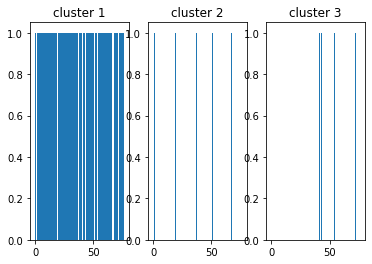

PCA:  2 components
cluster analysis algorithm: K-Means
Correctness on testing  set: 0.91



another algorithm (y/n):  n


In [8]:
alg.user_models(PrincipalComp,Y,dim)